# dense_1_Multiply_50_embeddings_7_epochs

# Deep recommender on top of Amason’s Clean Clothing Shoes and Jewelry explicit rating dataset

Frame the recommendation system as a rating prediction machine learning problem and create a hybrid architecture that mixes the collaborative and content based filtering approaches:
- Collaborative part: Predict items ratings in order to recommend to the user items that he is likely to rate high.
- Content based: use metadata inputs (such as price and title) about items to find similar items to recommend.

### - Create 2 explicit recommendation engine models based on 2 machine learning architecture using Keras: 
    1. a matrix factorization model  
    2. a deep neural network model.


### Compare the results of the different models and configurations to find the "best" predicting model

### Used the best model for recommending items to users

In [ ]:
### name of model
modname = 'dense_1_Multiply_50_embeddings_7_epochs'

### size of embedding
embedding_size = 50

### number of epochs
num_epochs = 7



In [ ]:
# import sys

# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install sagemaker-experiments
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install boto3
# !{sys.executable} -m pip install sagemaker
# !{sys.executable} -m pip install pyspark
# !{sys.executable} -m pip install ipython-autotime
# !{sys.executable} -m pip install surprise
# !{sys.executable} -m pip install smart_open
# !{sys.executable} -m pip install pyarrow
# !{sys.executable} -m pip install fastparquet

In [ ]:
# Check Jave version 
# !sudo yum -y update

In [ ]:
# # Need to use Java 1.8.0
# !sudo yum remove jre-1.7.0-openjdk -y

In [ ]:
!java -version

In [ ]:
# !sudo update-alternatives --config java

In [ ]:
# !pip install pyarrow fastparquet
# !pip install ipython-autotime
# !pip install tqdm pydot pydotplus pydot_ng

In [ ]:
#### To measure all running time
# https://github.com/cpcloud/ipython-autotime

%load_ext autotime

In [ ]:
%pylab inline
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import re
import seaborn as sbn
import nltk
import tqdm as tqdm
import sqlite3
import pandas as pd
import numpy as np
from pandas import DataFrame 
import string
import pydot 
import pydotplus
import pydot_ng
import pickle
import time
import gzip
import os
os.getcwd()
    
import matplotlib.pyplot as plt
from math import floor,ceil

#from nltk.corpus import stopwords
#stop = stopwords.words("english")
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')
from nltk.tokenize import word_tokenize

from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, auc,classification_report, mean_squared_error, mean_absolute_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection  import train_test_split
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.feature_selection import SelectKBest
from IPython.display import SVG

# Tensorflow
import tensorflow as tf

#Keras
from keras.models import Sequential, Model, load_model, save_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Embedding
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam
from keras.layers.core import Reshape, Dropout, Dense
from keras.layers.merge import Multiply, Dot, Concatenate
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import model_to_dot

### Set and Check GPUs

In [ ]:
#Session
from keras import backend as K

def set_check_gpu():
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.per_process_gpu_memory_fraction =1 # allow all of the GPU memory to be allocated
    # for 8 GPUs
    # cfg.gpu_options.visible_device_list = "0,1,2,3,4,5,6,7" # "0,1"
    # for 1 GPU
    cfg.gpu_options.visible_device_list = "0"
    #cfg.gpu_options.allow_growth = True  # # Don't pre-allocate memory; dynamically allocate the memory used on the GPU as-needed
    #cfg.log_device_placement = True  # to log device placement (on which device the operation ran)
    sess = K.tf.Session(config=cfg)
    K.set_session(sess)  # set this TensorFlow session as the default session for Keras

    print("* TF version: ", [tf.__version__, tf.test.is_gpu_available()])
    print("* List of GPU(s): ", tf.config.experimental.list_physical_devices() )
    print("* Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU'))) 
  
    
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";
    # set for 8 GPUs
#     os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7";
    # set for 1 GPU
    os.environ["CUDA_VISIBLE_DEVICES"] = "0";

    # Tf debugging option
    tf.debugging.set_log_device_placement(True)

    gpus = tf.config.experimental.list_physical_devices('GPU')

    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

#     print(tf.config.list_logical_devices('GPU'))
    print(tf.config.experimental.list_physical_devices('GPU'))
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [ ]:
set_check_gpu()

In [ ]:
# reset GPU memory& Keras Session
def reset_keras():
    try:
        del classifier
        del model    
    except:
        pass

    K.clear_session()
 
    K.get_session().close()
#    sess = K.get_session()

    cfg = K.tf.ConfigProto()
    cfg.gpu_options.per_process_gpu_memory_fraction 
#     cfg.gpu_options.visible_device_list = "0,1,2,3,4,5,6,7" # "0,1"
    cfg.gpu_options.visible_device_list = "0" # "0,1"
    cfg.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU

    sess = K.tf.Session(config=cfg)
    K.set_session(sess)  # set this TensorFlow session as the default session for Keras
    

## Load dataset and analysis using Spark

## Download and prepare Data:
#### 1. Read the data:
#### Read the data from the reviews dataset of amazon. 
#### Use the dastaset in which all users and items have at least 5 reviews. 

### Location of dataset: https://nijianmo.github.io/amazon/index.html

In [ ]:
import pandas as pd

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.analytics import ExperimentAnalytics

import gzip
import json

from pyspark.ml import Pipeline
from pyspark.sql.types import StructField, StructType, StringType, DoubleType
from pyspark.ml.feature import StringIndexer, VectorIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import *

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.evaluation import RegressionEvaluator

import os
import pandas as pd
import pyarrow
import fastparquet

# from pandas_profiling import ProfileReport

In [ ]:
# !aws s3 cp s3://dse-cohort5-group1/2-Keras-DeepRecommender/dataset/Clean_Clothing_Shoes_and_Jewelry_5_clean.parquet ./data/

In [ ]:
!ls -alh ./data

### Read clened dataset from parquet files

In [ ]:
review_data = pd.read_parquet("./data/Clean_Clothing_Shoes_and_Jewelry_5_clean.parquet")

In [ ]:
review_data[:3]

In [ ]:
review_data.shape

### 2. Arrange and clean the data

Rearrange the columns by relevance and rename column names

In [ ]:
review_data.columns

In [ ]:
review_data = review_data[['asin', 'image', 'summary', 'reviewText', 'overall', 'reviewerID', 'reviewerName', 'reviewTime']]

review_data.rename(columns={ 'overall': 'score','reviewerID': 'user_id', 'reviewerName': 'user_name'}, inplace=True)

#the variables names after rename in the modified data frame
list(review_data)

# Add Metadata 

### Metadata includes descriptions, price, sales-rank, brand info, and co-purchasing links
- asin - ID of the product, e.g. 0000031852
- title - name of the product
- price - price in US dollars (at time of crawl)
- imUrl - url of the product image
- related - related products (also bought, also viewed, bought together, buy after viewing)
- salesRank - sales rank information
- brand - brand name
- categories - list of categories the product belongs to

In [ ]:
# !aws s3 cp s3://dse-cohort5-group1/2-Keras-DeepRecommender/dataset/Cleaned_meta_Clothing_Shoes_and_Jewelry.parquet ./data/

In [ ]:
all_info = pd.read_parquet("./data/Cleaned_meta_Clothing_Shoes_and_Jewelry.parquet")

In [ ]:
all_info.head(n=5)

### Arrange and clean the data

- Cleaning, handling missing data, normalization, etc:
- For the algorithm in keras to work,  remap all item_ids and user_ids to an interger between 0 and the total number of users or the total number of items

In [ ]:
all_info.columns

In [ ]:
items = all_info.asin.unique()
item_map = {i:val for i,val in enumerate(items)}
inverse_item_map = {val:i for i,val in enumerate(items)}
all_info["old_item_id"] = all_info["asin"] # copying for join with metadata
all_info["item_id"] = all_info["asin"].map(inverse_item_map)
items = all_info.item_id.unique()
print ("We have %d unique items in metadata "%items.shape[0])

In [ ]:
all_info['description'] = all_info['description'].fillna(all_info['title'].fillna('no_data'))
all_info['title'] = all_info['title'].fillna(all_info['description'].fillna('no_data').apply(str).str[:20])
all_info['image'] = all_info['image'].fillna('no_data')
all_info['price'] = pd.to_numeric(all_info['price'],errors="coerce")
all_info['price'] = all_info['price'].fillna(all_info['price'].median()) 

In [ ]:
users = review_data.user_id.unique()
user_map = {i:val for i,val in enumerate(users)}
inverse_user_map = {val:i for i,val in enumerate(users)}
review_data["old_user_id"] = review_data["user_id"] 
review_data["user_id"] = review_data["user_id"].map(inverse_user_map)

items_reviewed = review_data.asin.unique()
review_data["old_item_id"] = review_data["asin"] # copying for join with metadata
review_data["item_id"] = review_data["asin"].map(inverse_item_map)

items_reviewed = review_data.item_id.unique()
users = review_data.user_id.unique()

In [ ]:
print ("We have %d unique users"%users.shape[0])
print ("We have %d unique items reviewed"%items_reviewed.shape[0])
# We have 192403 unique users in the "small" dataset
# We have 63001 unique items reviewed in the "small" dataset

In [ ]:
review_data.head(3)

## Adding the review count and avarage to the metadata

In [ ]:
#items_nb = review_data['old_item_id'].value_counts().reset_index()
items_avg = review_data.drop(['summary','reviewText','user_id','asin','user_name','reviewTime','old_user_id','item_id'],axis=1).groupby('old_item_id').agg(['count','mean']).reset_index()
items_avg.columns= ['old_item_id','num_ratings','avg_rating']
#items_avg.head(5)
items_avg['num_ratings'].describe()

In [ ]:
all_info =  pd.merge(all_info,items_avg,how='left',left_on='asin',right_on='old_item_id')
pd.set_option('display.max_colwidth', 100)
all_info.head(2)

# Explicit feedback (Reviewed Dataset) Recommender System

### Explicit feedback is when users gives voluntarily the rating information on what they like and dislike.

- In this case, I have explicit item ratings ranging from one to five.
- Framed the recommendation system as a rating prediction machine learning problem: 
    - Predict an item's ratings in order to be able to recommend to a user an item that he is likely to rate high if he buys it. `

### To evaluate the model, I randomly separate the data into a training and test set. 

In [ ]:
ratings_train, ratings_test = train_test_split( review_data, test_size=0.1, random_state=0)

In [ ]:
ratings_train.shape

In [ ]:
ratings_test.shape

## Adding Metadata to the train set
Create an architecture that mixes the collaborative and content based filtering approaches:
```
- Collaborative Part: Predict items ratings to recommend to the user items which he is likely to rate high according to learnt item & user embeddings (learn similarity from interactions).
- Content based part: Use metadata inputs (such as price and title) about items to recommend to the user contents similar to those he rated high (learn similarity of item attributes).
```

#### Adding the title and price - Add the metadata of the items in the training and test datasets.

In [ ]:
# # creating metadata mappings 
# titles = all_info['title'].unique()
# titles_map = {i:val for i,val in enumerate(titles)}
# inverse_titles_map = {val:i for i,val in enumerate(titles)}

# price = all_info['price'].unique()
# price_map = {i:val for i,val in enumerate(price)}
# inverse_price_map = {val:i for i,val in enumerate(price)}

# print ("We have %d prices" %price.shape)
# print ("We have %d titles" %titles.shape)


# all_info['price_id'] = all_info['price'].map(inverse_price_map)
# all_info['title_id'] = all_info['title'].map(inverse_titles_map)

# # creating dict from 
# item2prices = {}
# for val in all_info[['item_id','price_id']].dropna().drop_duplicates().iterrows():
#     item2prices[val[1]["item_id"]] = val[1]["price_id"]

# item2titles = {}
# for val in all_info[['item_id','title_id']].dropna().drop_duplicates().iterrows():
#     item2titles[val[1]["item_id"]] = val[1]["title_id"]
        


# # populating the rating dataset with item metadata info
# ratings_train["price_id"] = ratings_train["item_id"].map(lambda x : item2prices[x])
# ratings_train["title_id"] = ratings_train["item_id"].map(lambda x : item2titles[x])


# # populating the test dataset with item metadata info
# ratings_test["price_id"] = ratings_test["item_id"].map(lambda x : item2prices[x])
# ratings_test["title_id"] = ratings_test["item_id"].map(lambda x : item2titles[x])


## create rating train/test dataset and upload into S3

In [ ]:
# !aws s3 cp s3://dse-cohort5-group1/2-Keras-DeepRecommender/dataset/ratings_test.parquet ./data/
# !aws s3 cp s3://dse-cohort5-group1/2-Keras-DeepRecommender/dataset/ratings_train.parquet ./data/

In [ ]:
ratings_test = pd.read_parquet('./data/ratings_test.parquet')
ratings_train = pd.read_parquet('./data/ratings_train.parquet')

In [ ]:
ratings_train[:3]

In [ ]:
ratings_train.shape

# **Define embeddings
### The $\underline{embeddings}$ are low-dimensional hidden representations of users and items, 
### i.e. for each item I can find its properties and for each user I can encode how much they like those properties so I can determine attitudes or preferences of users by a small number of hidden factors 

### Throughout the training, I learn two new low-dimensional dense representations: one embedding for the users and another one for the items.


In [ ]:
price = all_info['price'].unique()
titles = all_info['title'].unique()

In [ ]:
# declare input embeddings to the model
# User input
user_id_input = Input(shape=[1], name='user')
# Item Input
item_id_input = Input(shape=[1], name='item')
price_id_input = Input(shape=[1], name='price')
title_id_input = Input(shape=[1], name='title')

# define the size of embeddings as a parameter
# Check 5, 10 , 15, 20, 50
user_embedding_size = embedding_size 
item_embedding_size = embedding_size
price_embedding_size = embedding_size
title_embedding_size = embedding_size

# apply an embedding layer to all inputs
user_embedding = Embedding(output_dim=user_embedding_size, input_dim=users.shape[0],
                               input_length=1, name='user_embedding')(user_id_input)

item_embedding = Embedding(output_dim=item_embedding_size, input_dim=items_reviewed.shape[0],
                               input_length=1, name='item_embedding')(item_id_input)

price_embedding = Embedding(output_dim=price_embedding_size, input_dim=price.shape[0],
                           input_length=1, name='price_embedding')(price_id_input)

title_embedding = Embedding(output_dim=title_embedding_size, input_dim=titles.shape[0],
                           input_length=1, name='title_embedding')(title_id_input)

# reshape from shape (batch_size, input_length,embedding_size) to (batch_size, embedding_size). 
user_vecs = Reshape([user_embedding_size])(user_embedding)
# user_vecs = Dropout(0.8)(user_vecs)
item_vecs = Reshape([item_embedding_size])(item_embedding)
# item_vecs = Dropout(0.8)(item_vecs)
price_vecs = Reshape([price_embedding_size])(price_embedding)
# price_vecs = Dropout(0.8)(price_vecs)
title_vecs = Reshape([title_embedding_size])(title_embedding)
# title_vecs = Dropout(0.8)(title_vecs)

# 2. Deep Recommender

### Instead of taking a dot product of the user and the item embedding, concatenate or multiply them and use them as features for a neural network. 
### Thus, we are not constrained to the dot product way of combining the embeddings, and can learn complex non-linear relationships.

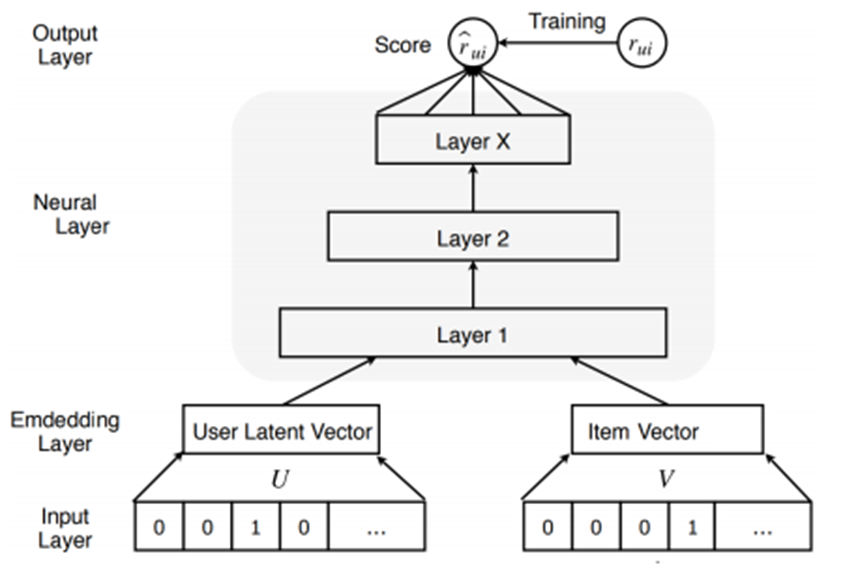






In [ ]:
!mkdir -p ./models

In [ ]:
# Try add dense layers on top of the embeddings before merging (Comment to drop this idea.)
user_vecs = Dense(64, activation='relu')(user_vecs)
# user_vecs = Dropout(0.6)(user_vecs)
item_vecs = Dense(64, activation='relu')(item_vecs)
# user_vecs = Dropout(0.6)(user_vecs)
# price_vecs = Dense(64, activation='relu')(price_vecs) 
# title_vecs = Dense(64, activation='relu')(title_vecs)

In [ ]:
# Concatenate the item embeddings :
# item_vecs_complete  = Concatenate()([item_vecs, price_vecs,title_vecs])

# Concatenate user and item embeddings and use them as features for the neural network:
# input_vecs = Concatenate()([user_vecs, item_vecs_complete]) # can be changed by Multiply
#input_vecs = Concatenate()([user_vecs, item_vecs]) # can be changed by Multiply

# Multiply user and item embeddings and use them as features for the neural network:
input_vecs = Multiply()([user_vecs, item_vecs]) # can be changed by concat 

# Dropout is a technique where randomly selected neurons are ignored during training to prevent overfitting 
input_vecs = Dropout(0.6)(input_vecs)  

# Check one dense 128 or two dense layers (128,128) or (128,64) or three denses layers (128,64,32))

# First layer
# Dense(128) is a fully-connected layer with 128 hidden units.
# Use rectified linear units (ReLU) f(x)=max(0,x) as an activation function.
x = Dense(128, activation='relu')(input_vecs)
x = Dropout(0.6)(x) # Add droupout or not # To improve the performance

# Next Layers
# x = Dense(128, activation='relu')(x) # Add dense again or not 
# x = Dropout(0.4)(x) # Add droupout or not # To improve the performance
# x = Dense(128, activation='relu')(x) # Add dense again or not 
# x = Dropout(0.1)(x) # Add droupout or not # To improve the performance
# x = Dense(32, activation='relu')(x) # Add dense again or not #
# x = Dropout(0.4)(x) # Add droupout or not # To improve the performance

# The output
y = Dense(1)(x)

In [ ]:
# create model
model = Model(inputs=
                    [
                      user_id_input,
                      item_id_input
                    ], 
              outputs=y)

# compile model
model.compile(loss='mse',
              optimizer="adam" )

# set save location for model
save_path = "./models"
thename = save_path + '/' + modname + '.h5'
mcheck = ModelCheckpoint(thename, monitor='val_loss', save_best_only=True)

# fit model
history = model.fit([ratings_train["user_id"]
                    , ratings_train["item_id"]
                    ]
                    , ratings_train["score"]
                    , batch_size=64
                    , epochs=num_epochs
                    , validation_split=0.1
                    , callbacks=[mcheck]
                    , shuffle=True)

In [ ]:
# Save the fitted model history to a file
with open('./histories/' + modname + '.pkl' , 'wb') as file_pi:  pickle.dump(history.history, file_pi)
    
print("Save history in ", './histories/' + modname + '.pkl')

In [ ]:
def disp_model(path,file,suffix):
    model = load_model(path+file+suffix)    
    ## Summarise the model 
    model.summary()    
    # Extract the learnt user and item embeddings, i.e., a table with number of items and users rows and columns, with number of columns is the dimension of the trained embedding.
    # In our case, the embeddings correspond exactly to the weights of the model:
    weights = model.get_weights()
    print ("embeddings \ weights shapes",[w.shape for w in weights])    
    return model
    
model_path = "./models/"

In [ ]:
def plt_pickle(path,file,suffix):
    with open(path+file+suffix , 'rb') as file_pi: 
        thepickle= pickle.load(file_pi)
        plot(thepickle["loss"],label ='Train Error ' + file,linestyle="--")
        plot(thepickle["val_loss"],label='Validation Error ' + file) 
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("Error")  
        ##plt.ylim(0, 0.1)
    return pd.DataFrame(thepickle,columns =['loss','val_loss'])

hist_path = "./histories/"

In [ ]:
print(model_path)
print(modname)
model=disp_model(model_path, modname, '.h5')

In [ ]:
# Display the model using keras
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
x=plt_pickle(hist_path , modname , '.pkl')
x.head(20).transpose()